In [1]:
%load_ext autoreload
%autoreload 2

# Import modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.optimize import linear_sum_assignment
import scipy.optimize
import scipy.io
from tqdm import tqdm
import os
from Tracking import *
from hist3d import *
import warnings

In [3]:
warnings.filterwarnings('ignore')

# Load Data

In [4]:
f1 = '10G0502'
f2 = '10G2603'
d1 = np.loadtxt('sample_data/10G0502.MTS.txt')
d2 = np.loadtxt('sample_data/10G2603.MTS.txt')
n_fish = 10
t_int = 1/25

# Track and correct data

In [5]:
def track_and_correct(x,y, n_fish=10):
    n_rows = len(x)//n_fish
    z = np.vstack((x,y)).T
    x = x.reshape((n_rows, n_fish))
    y = y.reshape((n_rows, n_fish))
    z = z.reshape((n_rows, n_fish, 2))
    
    tracker = Tracker(160, 25, 5, 0)
    ds = data_sheet()
    for i in tqdm(range(len(z)),desc='Tracking'):
        tracks = tracker.update(z[i])
        ds.update(tracks)

    data_tracked = ds.combine()
    x_tracked = data_tracked[:,2]
    y_tracked = data_tracked[:,3]
    z_tracked = np.vstack((x_tracked,y_tracked)).T

    x_tracked = x_tracked.reshape((len(x_tracked)//n_fish, n_fish))
    y_tracked = y_tracked.reshape(len(y_tracked)//n_fish, n_fish)
    z_tracked = z_tracked.reshape((len(x_tracked), n_fish, 2))
    
    k = z.copy()
    err_th = 10
    cost = np.zeros((n_fish, n_fish))
    for i in tqdm(range(len(z)), desc="Correcting"):
        for j in range(n_fish):
            cost[j,:] = np.sqrt(np.sum(np.square(k[i] - z_tracked[i][j]), axis=1))
        cost = 0.5*cost
        r,c = linear_sum_assignment(cost)
        k[i] = z[i][c]
        k[i][np.where(cost[r,c] > err_th)] = z_tracked[i][np.where(cost[r,c] > err_th)]

    return k.T[0].T, k.T[1].T

> ## Track and correct (rearrange) the original x,y coordinated based on the tracked data to resolve ID mismatch issue

Correcting: 100%|██████████| 5000/5000 [00:00<00:00, 6230.88it/s]


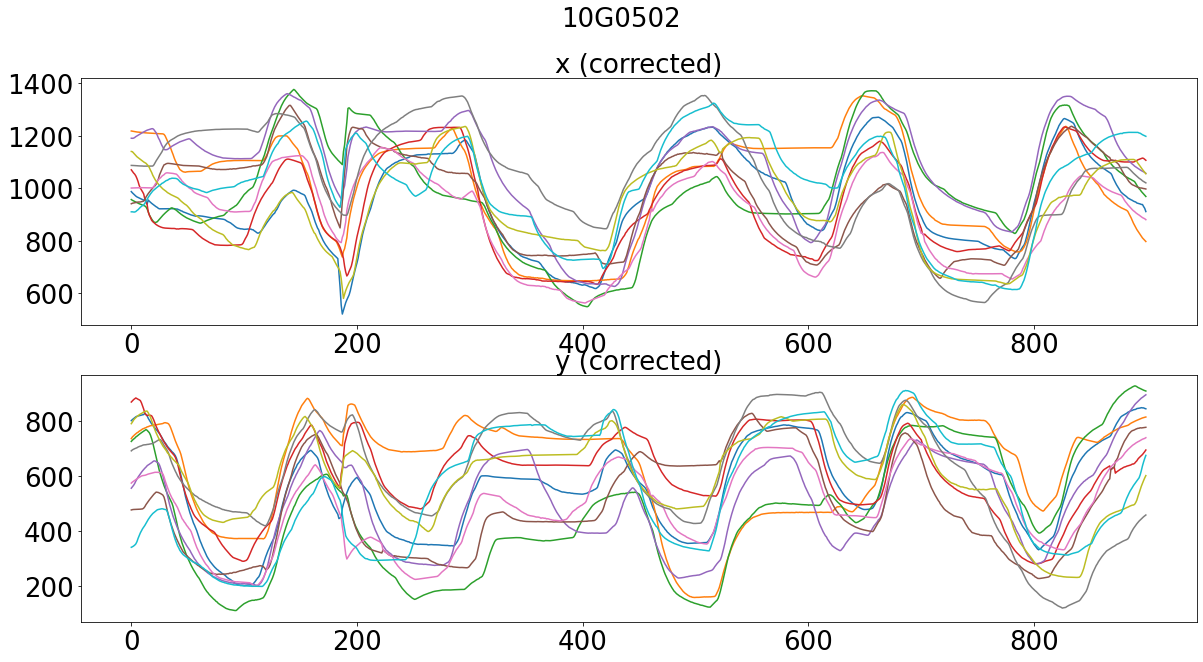

Correcting: 100%|██████████| 5000/5000 [00:00<00:00, 6442.31it/s]


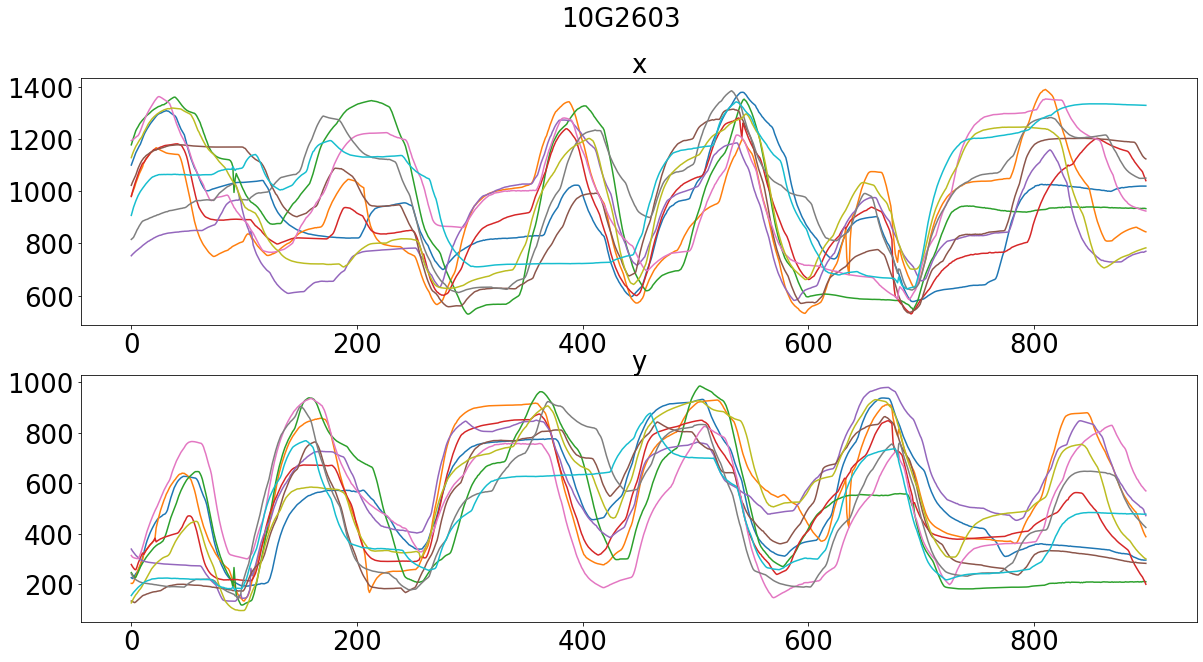

In [6]:
x1, y1 = d1.T[1:3]
xc1, yc1 = track_and_correct(x1, y1)
fig = plt.figure(figsize=(20,10))
plt.suptitle(f1, fontsize=26)
plt.subplot(2,1,1)
plt.title('x (corrected)', fontsize=26)
plt.plot(xc1[100:1000])
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.subplot(2,1,2)
plt.title('y (corrected)', fontsize=26)
plt.plot(yc1[100:1000])
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.show()

x2, y2 = d2.T[1:3]
xc2, yc2 = track_and_correct(x2,y2)
fig = plt.figure(figsize=(20,10))
plt.suptitle(f2, fontsize=26)
plt.subplot(2,1,1)
plt.title('x', fontsize=26)
plt.plot(xc2[100:1000])
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.subplot(2,1,2)
plt.title('y', fontsize=26)
plt.plot(yc2[100:1000])
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.show()

np.savetxt('sample_data/10G0502.C.txt', np.vstack((xc1.flatten(), yc1.flatten())).T, fmt='%d')
np.savetxt('sample_data/10G2603.C.txt', np.vstack((xc2.flatten(), yc2.flatten())).T, fmt='%d')

> ## <span style="color:blue">Thus, from the plots above, the ID swapp/track id mismatch issue is resolved</span>

# Plot Mx My hist
> ## Check if the characterstics of data are similar after tracking and correcting

In [7]:
def pol(x,y,t_int=t_int):
    vel_x = np.diff(x.round(), axis=0)/t_int
    vel_y = np.diff(y.round(), axis=0)/t_int
    vel = np.sqrt(vel_x**2 + vel_y**2)
    mx = vel_x/vel
    mx[np.isnan(mx)] = 0
    my = vel_y/vel
    my[np.isnan(my)] = 0
    Mx = np.mean(mx, axis=1)
    My = np.mean(my, axis=1)
    M = np.sqrt(Mx**2 + My**2)
    return Mx, My, M

In [8]:
Mx_c1, My_c1, M_c1 = pol(xc1, yc1)
Mx_c2, My_c2, M_c2 = pol(xc2, yc2)

Text(0.5, 1.0, '10G2603; |M|=0.471')

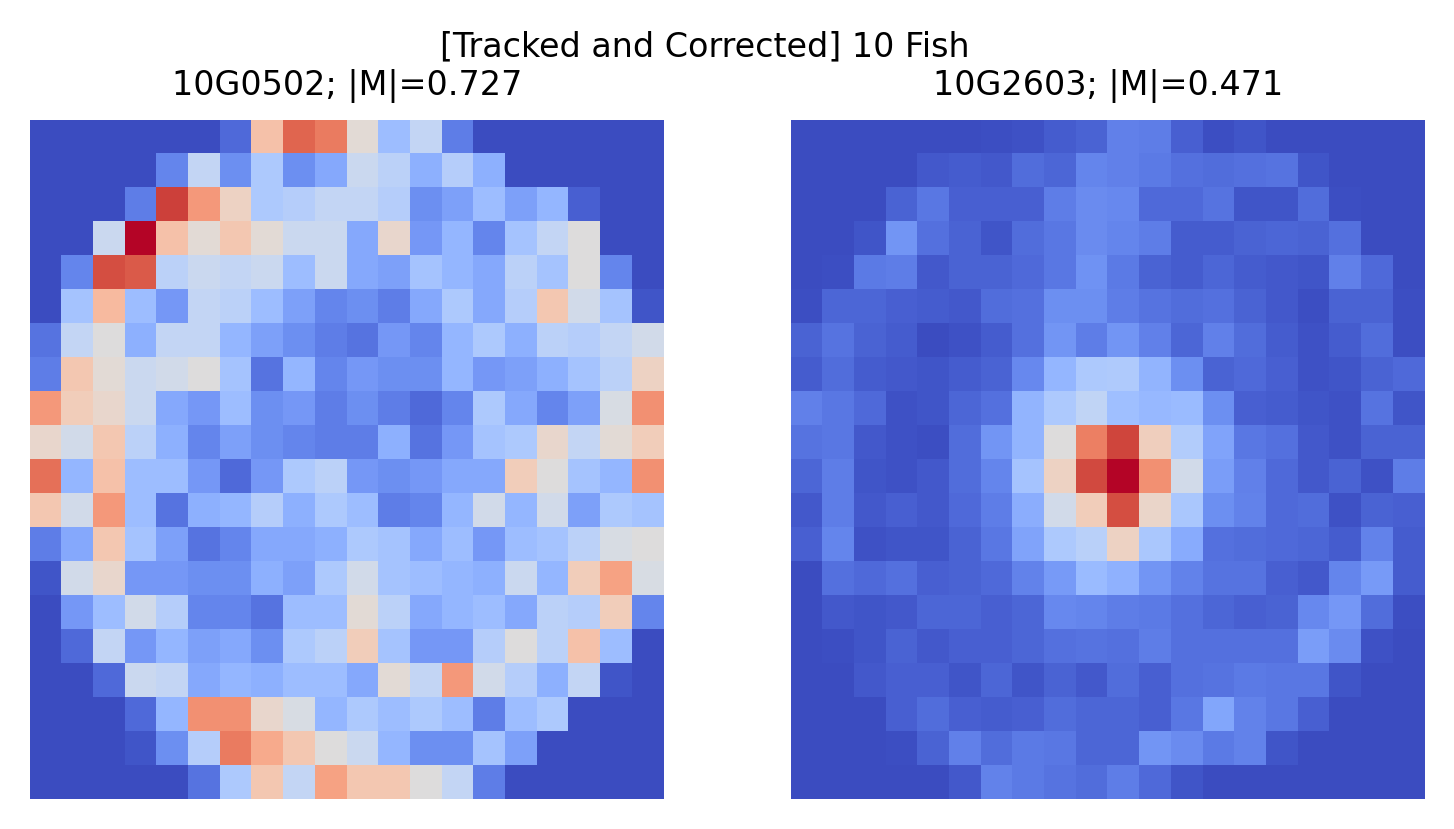

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=300)
fig.suptitle('[Tracked and Corrected] 10 Fish', fontsize=8)
H, edges, X, Y, Z, dx, dy, dz = histogram_3d(np.array([Mx_c1, My_c1]))
bin_count = int(np.sqrt(len(dz)))
dz = dz.reshape((bin_count, bin_count))
ax[0].xaxis.set_major_locator(plt.NullLocator())
ax[0].yaxis.set_major_locator(plt.NullLocator())
sns.heatmap(dz,xticklabels=[], yticklabels=[],cmap=plt.cm.coolwarm,cbar=False, ax=ax[0])
M = M_c1.mean().round(3)
ax[0].set_title("{}; |M|={}".format(f1, M), fontsize=8)


H, edges, X, Y, Z, dx, dy, dz = histogram_3d(np.array([Mx_c2, My_c2]))
bin_count = int(np.sqrt(len(dz)))
dz = dz.reshape((bin_count, bin_count))
ax[1].xaxis.set_major_locator(plt.NullLocator())
ax[1].yaxis.set_major_locator(plt.NullLocator())
sns.heatmap(dz,xticklabels=[], yticklabels=[],cmap=plt.cm.coolwarm,cbar=False, ax=ax[1])
M = M_c2.mean().round(3)
ax[1].set_title("{}; |M|={}".format(f2, M), fontsize=8)

> ## <span style="color:red">Even after tracking and correcting the data, the data features are not similar.</span>
> #### But there is some improvements with the mean polarisation

# <span style="color:blue">After further analysis we find the reason for such deviation in characterstics is caused by the some "idle fish" (fish that are not moving).</span>.